In [1]:
# In this notebook, we explore the llc contention impact by fixing the traffic input rate

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import causallearn
import re

from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import io
import os
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib as mp
from matplotlib.ticker import FuncFormatter

In [3]:
import pandas as pd

# Path to your CSV file
csv_file = '..\\datasets\\ONVM-nDPI-stats_0xf.csv'

# Read the CSV file
df = pd.read_csv(csv_file, header=[0, 1])
print(df)

    Unnamed: 0_level_0 ndpi_stats-pcm_new_System-Date  \
                     0                     2023-11-28   
0                    1                     2023-11-28   
1                    2                     2023-11-28   
2                    3                     2023-11-28   
3                    4                     2023-11-28   
4                    5                     2023-11-28   
..                 ...                            ...   
192                193                     2023-11-28   
193                194                     2023-11-28   
194                195                     2023-11-28   
195                196                     2023-11-28   
196                197                     2023-11-28   

    ndpi_stats-pcm_new_System-Time ndpi_stats-pcm_new_Socket 0-EXEC  \
                      12:59:54.616                             0.48   
0                     12:59:55.616                             0.48   
1                     12:59:56.617           

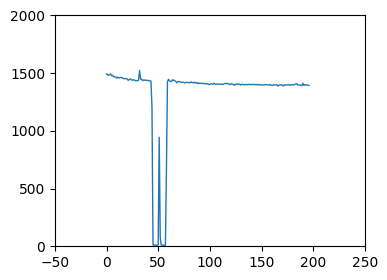

In [4]:
fig, ax = plt.subplots(facecolor='white', figsize=(4,3))
plt.style.use('classic')
xx=df['pcm-memory_new_System-Read']
ax.set_ylim([0,2000])
ax.plot(xx)

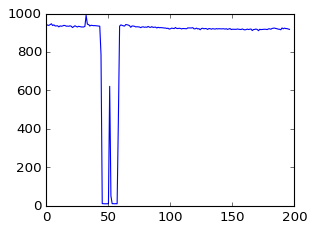

In [5]:
fig, ax = plt.subplots(facecolor='white', figsize=(4,3))
plt.style.use('classic')
xx=df['pcm-memory_new_System-Write']
ax.plot(xx)

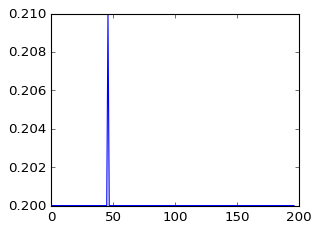

In [6]:
fig, ax = plt.subplots(facecolor='white', figsize=(4,3))
plt.style.use('classic')
xx=df['ndpi_stats-pcm_new_Socket 0-FREQ']
ax.plot(xx)

# cache sensitive

In [8]:
exp_ls = f'0x10'

In [9]:
def extract_specific_data(exp_ls):
    file_path = f'..\\data\\ONVM-nDPI-stats\\{exp_ls}\\traffic_profile.txt'
    
    # Regular expression patterns for required data
    tx_pattern = r"\[Device: id=0\] TX: ([\d.]+)"
    rx_pattern = r"\[Device: id=1\] RX: ([\d.]+)"
    stddev_rx_pattern = r"\[Device: id=1\] RX: [\d.]+ \(StdDev ([\d.]+)\)"  # Adjusted pattern
    average_pattern = r"Average: ([\d.]+) ns"

    # Variables to store the extracted data
    tx_value, rx_value, stddev_rx, average = None, None, None, None

    # Read the text file
    with open(file_path, 'r') as file:
        for line in file:
            if tx_match := re.search(tx_pattern, line):
                tx_value = round(float(tx_match.group(1)), 2)
            elif rx_match := re.search(rx_pattern, line):
                rx_value = round(float(rx_match.group(1)), 2)
            elif stddev_rx_match := re.search(stddev_rx_pattern, line):
                stddev_rx = round(float(stddev_rx_match.group(1)), 2)
            elif average_match := re.search(average_pattern, line):
                average = round(float(average_match.group(1)), 2)

    return tx_value, rx_value, average



# Usage example
input_file_path = f'..\\data\\ONVM-nDPI-stats\\{exp_ls}\\traffic_profile.txt'
data =  extract_specific_data(f'0x10')
print(data)


(5.66, 4.78, 7420799.4)


In [10]:
# compare for different LLC ways: exp0x1, 0x3,0xf,0xfffff

input_rate = [extract_specific_data(f'0x10')[0], extract_specific_data(f'0x3')[0], extract_specific_data(f'0xf')[0], extract_specific_data(f'0xfffff')[0] ]
output_rate = [extract_specific_data(f'0x10')[1], extract_specific_data(f'0x3')[1], extract_specific_data(f'0xf')[1], extract_specific_data(f'0xfffff')[1]]
latency = [extract_specific_data(f'0x10')[2], extract_specific_data(f'0x3')[2], extract_specific_data(f'0xf')[2], extract_specific_data(f'0xfffff')[2]]

print(input_rate)
print(output_rate)
print(latency)

[5.66, 5.65, 5.49, 5.59]
[4.78, 5.43, 5.42, 5.51]
[7420799.4, 1313955.1, 11137.8, 12144.5]


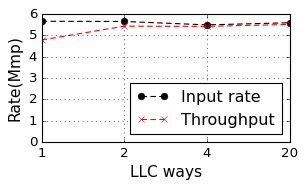

In [12]:
fig, ax = plt.subplots(facecolor='white', figsize=(4,2))
plt.style.use('classic')
xx = ["1","2","4","20"]
#xx=[1,2,4,20]
ax.plot(xx,input_rate, marker='o', markersize=6, c='k', linewidth=1, dashes=(5, 3), label="Input rate")
ax.plot(xx, output_rate, marker='x', markersize=6, c='r', linestyle='-', linewidth=1, dashes=(5, 3), label='Throughput')
ax.legend(loc='lower right')
ax.set_ylim([0,6])
ax.set_xlabel(f'LLC ways', size='14')
ax.set_ylabel('Rate(Mmp)', size='14')
ax.grid()
#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_throughput.pdf' )
plt.savefig(file_path,bbox_inches='tight')
plt.show()

In [13]:
print(latency)

[7420799.4, 1313955.1, 11137.8, 12144.5]


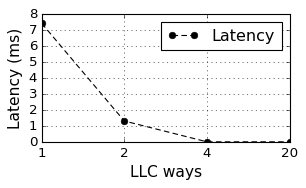

In [15]:
fig, ax = plt.subplots(facecolor='white', figsize=(4,2))
plt.style.use('classic')
xx = ["1","2","4","20"]
#xx=[1,2,4,20]
ax.plot(xx,[i/1000000 for i in latency], marker='o', markersize=6, c='k', linestyle='-', linewidth=1, dashes=(5, 3), label="Latency")
ax.set_xlabel(f'LLC ways', size='14')
ax.set_ylabel("Latency (ms)", size='14')
ax.legend(loc='upper right')
#ax.set_ylim([0,6])
ax.grid()
#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_latency.pdf' )
plt.savefig(file_path,bbox_inches='tight')
plt.show()

In [12]:
# compare for same LLC ways under different location: exp0x1, 0x3,0xf,0xfffff

input_rate = [extract_specific_data(f'0x10')[0], extract_specific_data(f'0x1')[0], extract_specific_data(f'0x10000')[0], extract_specific_data(f'0x2')[0] ]
output_rate = [extract_specific_data(f'0x10')[1], extract_specific_data(f'0x1')[1], extract_specific_data(f'0x10000')[1], extract_specific_data(f'0x2')[1]]
latency = [extract_specific_data(f'0x10')[2], extract_specific_data(f'0x1')[2], extract_specific_data(f'0x10000')[2], extract_specific_data(f'0x2')[2]]

print(input_rate)
print(output_rate)
print(latency)

[5.66, 5.63, 5.65, 5.64]
[4.78, 4.78, 4.76, 4.71]
[7420799.4, 7319947.4, 7276230.2, 7479633.3]


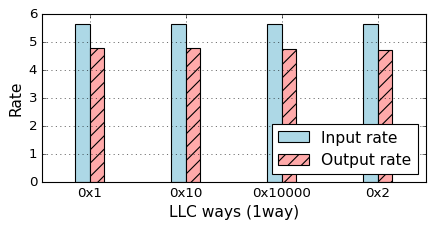

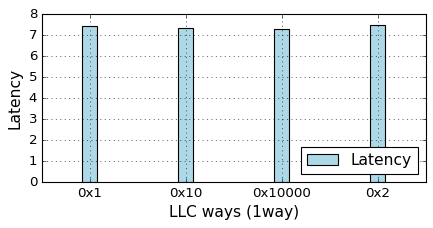

In [14]:
import matplotlib.pyplot as plt

# Assuming your extract_specific_data function and input data are defined as before
color_input = 'lightblue'
color_output = '#FFAAAA'


input_rate = [extract_specific_data(f'0x10')[0], extract_specific_data(f'0x1')[0], extract_specific_data(f'0x10000')[0], extract_specific_data(f'0x2')[0] ]
output_rate = [extract_specific_data(f'0x10')[1], extract_specific_data(f'0x1')[1], extract_specific_data(f'0x10000')[1], extract_specific_data(f'0x2')[1]]
latency = [extract_specific_data(f'0x10')[2], extract_specific_data(f'0x1')[2], extract_specific_data(f'0x10000')[2], extract_specific_data(f'0x2')[2]]

# First plot for input and output rates
fig, ax = plt.subplots(facecolor='white', figsize=(6, 3))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
xx = ["0x1","0x10","0x10000","0x2"]
bar_width = 0.15  # Width of the bars
index = range(len(xx))
# Set the width of the bars
bar_width = 0.15

# Calculate the positions for the bars on the x-axis
x_pos_scale = 0.7
x_pos = [x * x_pos_scale for x in range(len(input_rate))]
x_pos_input_rate = [x - bar_width/2 for x in x_pos]
x_pos_output_rate = [x + bar_width/2 for x in x_pos]
# Creating bar plots
ax.bar([i - bar_width/2 for i in index], input_rate, bar_width,  label="Input rate", color=color_input)
ax.bar([i + bar_width/2 for i in index], output_rate, bar_width, label='Output rate', color=color_output, hatch='//', edgecolor="black")

ax.legend(loc='lower right', fontsize=14)
ax.set_ylim([0, 6])
ax.set_xlabel('LLC ways (1way)', size='14')
ax.set_ylabel('Rate', size='14')
ax.set_xticks(index)
ax.set_xticklabels(xx)
ax.grid()

#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_throughput_1way.pdf' )
plt.savefig(file_path,bbox_inches='tight')
plt.show()

# Second plot for latency
fig, ax = plt.subplots(facecolor='white', figsize=(6, 3))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
ax.bar(index, [i/1000000 for i in latency], bar_width, color=color_input, label="Latency")

ax.set_xlabel('LLC ways (1way)', size='14')
ax.set_ylabel("Latency", size='14')
ax.legend(loc='lower right', fontsize=14)
#ax.set_ylim([0, 10])
ax.set_xticks(index)
ax.set_xticklabels(xx)
ax.grid()

#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_latency_1way.pdf' )
plt.savefig(file_path,bbox_inches='tight')
plt.show()


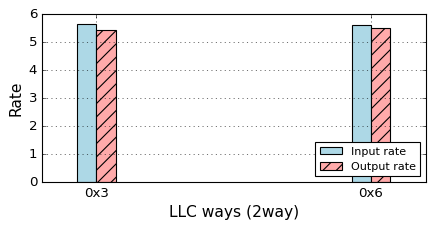

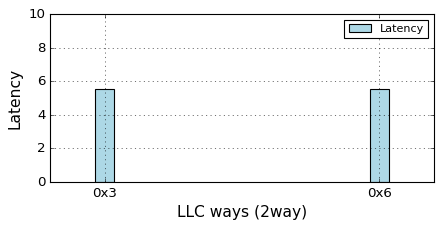

In [151]:
import matplotlib.pyplot as plt

# Assuming your extract_specific_data function and input data are defined as before
color_input = 'lightblue'
color_output = '#FFAAAA'


input_rate = [extract_specific_data(f'0x3')[0], extract_specific_data(f'0x6')[0]]
output_rate = [extract_specific_data(f'0x3')[1], extract_specific_data(f'0x6')[1]]
latency = [extract_specific_data(f'0x6')[2], extract_specific_data(f'0x6')[2]]

# First plot for input and output rates
fig, ax = plt.subplots(facecolor='white', figsize=(6, 3))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
xx = ["0x3", "0x6"]
bar_width = 0.07  # Width of the bars
index = range(len(xx))

# Creating bar plots
ax.bar([i - bar_width/2 for i in index], input_rate, bar_width,  label="Input rate", color=color_input)
ax.bar([i + bar_width/2 for i in index], output_rate, bar_width, label='Output rate', color=color_output, hatch='//', edgecolor="black")

ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 6])
ax.set_xlabel('LLC ways (2way)', size='14')
ax.set_ylabel('Rate', size='14')
ax.set_xticks(index)
ax.set_xticklabels(xx)
ax.grid()
#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_throughput_2way.pdf' )
plt.savefig(file_path,bbox_inches='tight')
plt.show()
# Second plot for latency
fig, ax = plt.subplots(facecolor='white', figsize=(6, 3))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
ax.bar(index, [i/100000 for i in latency], bar_width, color=color_input, label="Latency")

ax.set_xlabel('LLC ways (2way)', size='14')
ax.set_ylabel("Latency", size='14')
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim([0, 10])
ax.set_xticks(index)
ax.set_xticklabels(xx)
ax.grid()

#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_latency_2way.pdf' )
plt.savefig(file_path,bbox_inches='tight')
plt.show()


# sensitive feature

In [18]:
exp_ls= "ONVM-nDPI-stats_0x3.csv"
file_path =  f'..\\datasets\\{exp_ls}'
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 197
Data columns (total 96 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   ndpi_stats-pcm_new_System-Date                   198 non-null    object 
 1   ndpi_stats-pcm_new_System-Time                   198 non-null    object 
 2   ndpi_stats-pcm_new_Socket 0-EXEC                 198 non-null    float64
 3   ndpi_stats-pcm_new_Socket 0-IPC                  198 non-null    float64
 4   ndpi_stats-pcm_new_Socket 0-FREQ                 198 non-null    float64
 5   ndpi_stats-pcm_new_Socket 0-AFREQ                198 non-null    float64
 6   ndpi_stats-pcm_new_Socket 0-L3MISS               198 non-null    float64
 7   ndpi_stats-pcm_new_Socket 0-L2MISS               198 non-null    float64
 8   ndpi_stats-pcm_new_Socket 0-L3HIT                198 non-null    float64
 9   ndpi_stats-pcm_new_Socket 0-L2HI

C:\Users\Qiong\AppData\Local\Temp\ipykernel_17352\2632171634.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


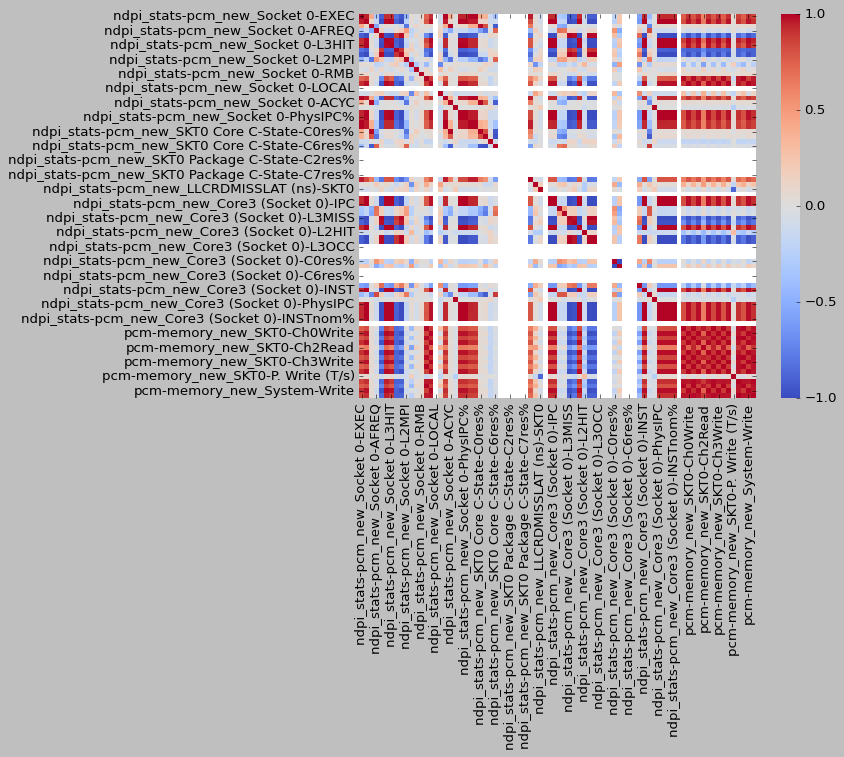

In [19]:
# heatmap
import seaborn as sns   
corr = data.corr()
plt.figure()
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f")

plt.show()

['ndpi_stats-pcm_new_Core3 (Socket 0)-L3MISS', 'ndpi_stats-pcm_new_Socket 0-L3MISS', 'ndpi_stats-pcm_new_Core3 (Socket 0)-L3MPI', 'ndpi_stats-pcm_new_Core3 (Socket 0)-L2MPI', 'ndpi_stats-pcm_new_Socket 0-L3MPI', 'ndpi_stats-pcm_new_Core3 (Socket 0)-L2MISS', 'ndpi_stats-pcm_new_Socket 0-L2HIT', 'ndpi_stats-pcm_new_Core3 (Socket 0)-TEMP']


C:\Users\Qiong\AppData\Local\Temp\ipykernel_17352\30927964.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  efficiency_correlations = data.corr()['efficiency'].sort_values(ascending=False)


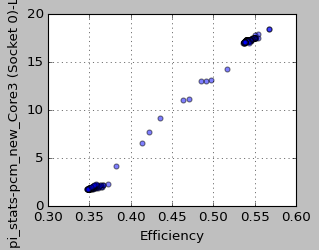

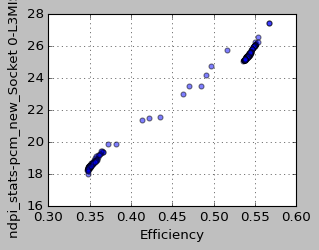

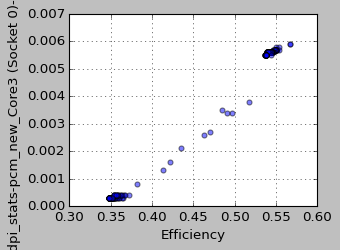

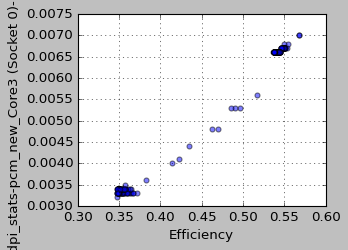

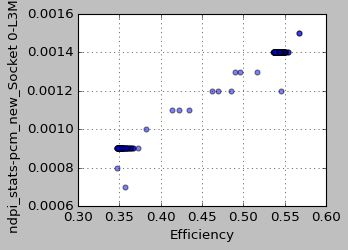

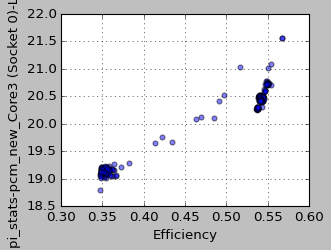

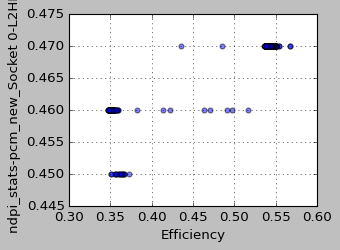

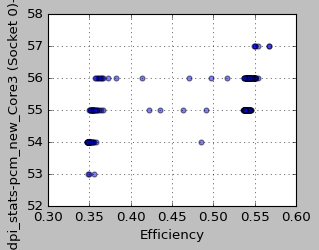

In [22]:
import matplotlib.pyplot as plt

data['efficiency'] = data.iloc[:, 6] / data.iloc[:, 7]

efficiency_correlations = data.corr()['efficiency'].sort_values(ascending=False)

high_corr_columns = [col for col in efficiency_correlations.index if efficiency_correlations[col] > 0.65 and col != 'efficiency']
print(high_corr_columns)
# Plotting
for column in high_corr_columns:
    plt.figure(figsize=(4,3))
    plt.scatter(data['efficiency'], data[column], alpha=0.5)
    plt.xlabel('Efficiency')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()


In [23]:
import pandas as pd

def average_feature(file_path):
    df = pd.read_csv(file_path)
    averages = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]) or pd.api.types.is_bool_dtype(df[column]):
            averages[column] = df[column].mean()

    return averages


In [34]:
exp_ls= "0x3"
file_path =  f'..\\datasets\\ONVM-nDPI-stats_{exp_ls}.csv'
a = average_feature(file_path)

In [36]:
file_name = ["0x1","0x10","0x2","0x3","0x6","0xf","0xfffff"]
feature_set = {}
for name in file_name:
    file_path =  f'..\\datasets\\ONVM-nDPI-stats_{name}.csv'
    compare_set[name] = average_feature(file_path)

In [37]:
def extract_specific_data(exp_ls):
    file_path = f'..\\data\\ONVM-nDPI-stats\\{exp_ls}\\traffic_profile.txt'
    
    # Regular expression patterns for required data
    tx_pattern = r"\[Device: id=0\] TX: ([\d.]+)"
    rx_pattern = r"\[Device: id=1\] RX: ([\d.]+)"
    stddev_rx_pattern = r"\[Device: id=1\] RX: [\d.]+ \(StdDev ([\d.]+)\)"  # Adjusted pattern
    average_pattern = r"Average: ([\d.]+) ns"

    # Variables to store the extracted data
    tx_value, rx_value, stddev_rx, average = None, None, None, None

    # Read the text file
    with open(file_path, 'r') as file:
        for line in file:
            if tx_match := re.search(tx_pattern, line):
                tx_value = round(float(tx_match.group(1)), 2)
            elif rx_match := re.search(rx_pattern, line):
                rx_value = round(float(rx_match.group(1)), 2)
            elif stddev_rx_match := re.search(stddev_rx_pattern, line):
                stddev_rx = round(float(stddev_rx_match.group(1)), 2)
            elif average_match := re.search(average_pattern, line):
                average = round(float(average_match.group(1)), 2)

    return tx_value, rx_value, average



# Usage example
data =  extract_specific_data(f'0x10')
print(data)


(5.66, 4.78, 7420799.4)


In [41]:
file_name = ["0x1","0x10","0x2","0x3","0x6","0xf","0xfffff"]
feature_set = {}
for name in file_name:
    file_path =  f'..\\datasets\\ONVM-nDPI-stats_{name}.csv'
    feature_set[name] = average_feature(file_path)

In [42]:
input_set = {}
output_set = {}
latency_set = {}
for name in file_name:
    file_path =  f'..\\datasets\\ONVM-nDPI-stats_{name}.csv'
    input_set[name] = extract_specific_data(name)[0]
    output_set[name] = extract_specific_data(name)[1]
    latency_set[name] = extract_specific_data(name)[2]  

In [44]:
# correlation
print(len(input_set))
print(len(feature_set))

7
7


In [46]:
print(feature_set)

{'0x1': {'Unnamed: 0': 98.5, 'ndpi_stats-pcm_new_Socket 0-EXEC': 0.31999999999999995, 'ndpi_stats-pcm_new_Socket 0-IPC': 1.6073232323232323, 'ndpi_stats-pcm_new_Socket 0-FREQ': 0.2002525252525252, 'ndpi_stats-pcm_new_Socket 0-AFREQ': 1.3046464646464648, 'ndpi_stats-pcm_new_Socket 0-L3MISS': 36.229343434343434, 'ndpi_stats-pcm_new_Socket 0-L2MISS': 54.84681818181819, 'ndpi_stats-pcm_new_Socket 0-L3HIT': 0.3409595959595961, 'ndpi_stats-pcm_new_Socket 0-L2HIT': 0.3641919191919191, 'ndpi_stats-pcm_new_Socket 0-L3MPI': 0.0023747474747474744, 'ndpi_stats-pcm_new_Socket 0-L2MPI': 0.003583333333333334, 'ndpi_stats-pcm_new_Socket 0-L3OCC': 15128.282828282829, 'ndpi_stats-pcm_new_Socket 0-LMB': 0.5, 'ndpi_stats-pcm_new_Socket 0-RMB': 0.0, 'ndpi_stats-pcm_new_Socket 0-READ': 2.5312626262626265, 'ndpi_stats-pcm_new_Socket 0-WRITE': 1.0512121212121215, 'ndpi_stats-pcm_new_Socket 0-LOCAL': 100.0, 'ndpi_stats-pcm_new_Socket 0-TEMP': 54.03030303030303, 'ndpi_stats-pcm_new_Socket 0-INST': 15287.0432828

In [47]:
print(input_set)

{'0x1': 5.63, '0x10': 5.66, '0x2': 5.64, '0x3': 5.65, '0x6': 5.62, '0xf': 5.49, '0xfffff': 5.59}


In [48]:
print(output_set)

{'0x1': 4.78, '0x10': 4.78, '0x2': 4.71, '0x3': 5.43, '0x6': 5.5, '0xf': 5.42, '0xfffff': 5.51}
